In [4]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set() 

## Importing The Data

In [5]:
data_wind = pd.read_csv('TexasTurbine.csv')
df = data_wind.copy()

In [6]:
df.head()

,Time stamp,System power generated | (kW),Wind speed | (m/s),Wind direction | (deg),Pressure | (atm),Air temperature | ('C)
0,"Jan 1, 12:00 am",1766.64,9.926,128,1.000480,18.263
1,"Jan 1, 01:00 am",1433.83,9.273,135,0.999790,18.363
2,"Jan 1, 02:00 am",1167.23,8.660,142,0.999592,18.663
3,"Jan 1, 03:00 am",1524.59,9.461,148,0.998309,18.763
4,"Jan 1, 04:00 am",1384.28,9.184,150,0.998507,18.963


## Data Preprocessing

In [7]:
from datetime import datetime

def con_date(x):
    d = datetime.strptime(x, '%b %d, %I:%M %p')
    return(pd.to_datetime(d.replace(year=d.year + 120)))

df['time_stamp'] = df['Time stamp'].apply(lambda x : con_date(x))
df = df.set_index('time_stamp')

In [8]:
df.dtypes

Time stamp                        object
System power generated | (kW)    float64
Wind speed | (m/s)               float64
Wind direction | (deg)             int64
Pressure | (atm)                 float64
Air temperature | ('C)           float64
dtype: object

In [9]:
df.drop('Time stamp', axis=1, inplace=True)
df = df.asfreq('H')
df = df.fillna(method='ffill')

In [10]:
df.isna().sum()

System power generated | (kW)    0
Wind speed | (m/s)               0
Wind direction | (deg)           0
Pressure | (atm)                 0
Air temperature | ('C)           0
dtype: int64

In [11]:
df.dtypes

System power generated | (kW)    float64
Wind speed | (m/s)               float64
Wind direction | (deg)           float64
Pressure | (atm)                 float64
Air temperature | ('C)           float64
dtype: object

In [12]:
df.rename({
    'System power generated | (kW)': 'power',
    'Wind speed | (m/s)': 'wind_speed',
    'Wind direction | (deg)': 'wind_direction',
    'Pressure | (atm)': 'pressure',
    'Air temperature | (\'C)': 'temperature'
}, inplace=True, axis=1)

## Finding the best model

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX 

In [14]:
df.tail()

,power,wind_speed,wind_direction,pressure,temperature
time_stamp,,,,,
2020-12-31 19:00:00,1234.70,8.848,129.0,0.998604,19.663
2020-12-31 20:00:00,1105.37,8.502,118.0,1.000090,19.063
2020-12-31 21:00:00,1405.71,9.224,117.0,0.998408,18.463
2020-12-31 22:00:00,1221.36,8.799,116.0,0.998013,18.063
2020-12-31 23:00:00,1676.77,9.748,121.0,1.000380,18.163


C:\Users\Repoo\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


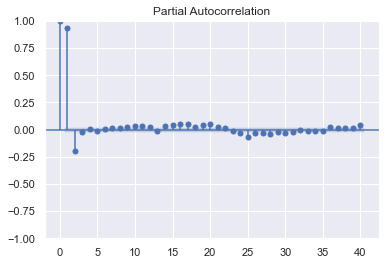

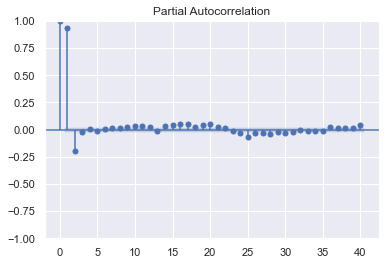

In [29]:
plot_pacf(df.power)

In [40]:
model_auto = SARIMAX(df.power,
                     df[['wind_speed']],
                     order = (3,1,13),
                     sesonal_order=(0,0,0,1),
                     enforce_stationary=True,
                     enforce_invertibility=True)
model_res = model_auto.fit()

C:\Users\Repoo\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [39]:
model_res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  power   No. Observations:                 8784
Model:              SARIMAX(3, 0, 13)   Log Likelihood              -57289.220
Date:                Wed, 15 Dec 2021   AIC                         114614.441
Time:                        10:59:44   BIC                         114741.893
Sample:                    01-01-2020   HQIC                        114657.862
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
wind_speed   212.7396      0.918    231.662      0.000     210.940     214.540
ar.L1          1.2145      0.002    519.327      0.000       1.210       1.219
ar.L2         -1.2137      0.003   -442.876      0.000      -1.219      -1.208
ar.L3          0.9992      0.002    660.758      0.000       0.996       1.002
ma.L1         -0.2140      0.010    -21.436      0.000      -0.234      -0.194
ma.L2          1.0287      0.010     99.155      0.000       1.008       1.049
ma.L3         -0.1169      0.016     -7.415      0.000      -0.148      -0.086
ma.L4         -0.0756      0.017     -4.535      0.000      -0.108      -0.043
ma.L5         -0.2047      0.017    -11.852      0.000      -0.239      -0.171
ma.L6         -0.1619      0.018     -9.195      0.000      -0.196      -0.127
ma.L7         -0.1832      0.017    -10.664      0.000      -0.217      -0.150
ma.L8         -0.1547      0.017     -9.272      0.000      -0.187      -0.122
ma.L9         -0.1865      0.017    -10.937      0.000      -0.220      -0.153
ma.L10        -0.0699      0.018     -3.979      0.000      -0.104      -0.035
ma.L11        -0.3963      0.017    -22.687      0.000      -0.431      -0.362
ma.L12         0.0657      0.012      5.468      0.000       0.042       0.089
ma.L13        -0.2574      0.012    -22.294      0.000      -0.280      -0.235
sigma2      3.434e+04      0.001   4.88e+07      0.000    3.43e+04    3.43e+04
===================================================================================
Ljung-Box (L1) (Q):                  18.06   Jarque-Bera (JB):              5456.11
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.03e+22. Standard errors may be unstable.
"""

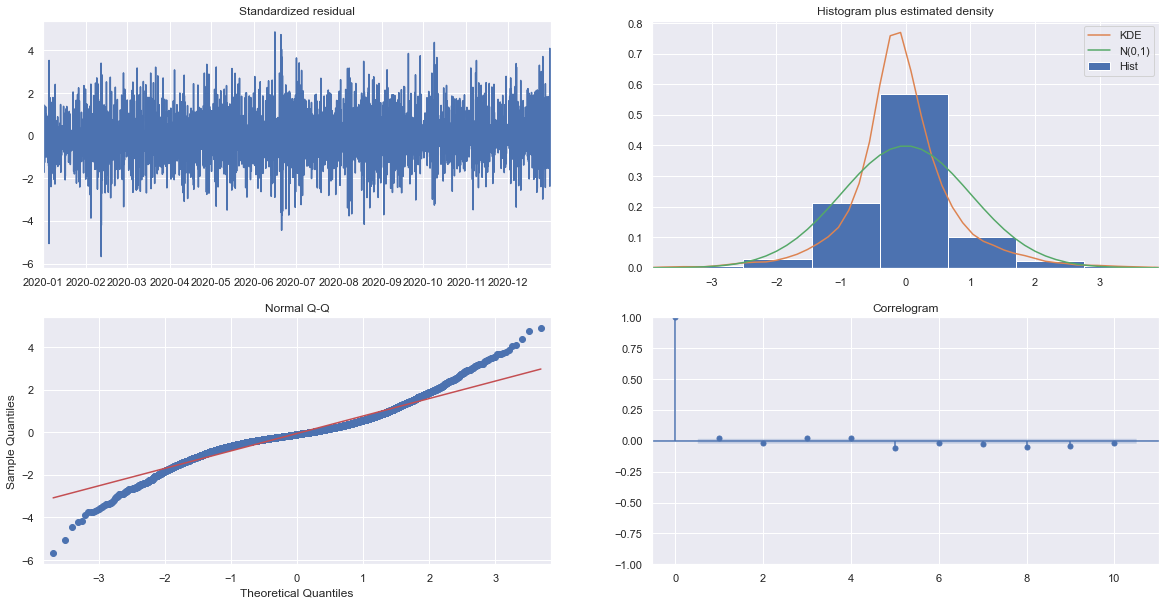

In [ ]:
model_auto.plot_diagnostics(figsize=(20,10))
plt.show()

## predicting the next 24 steps

In [ ]:
# u can change steps variable to any number of steps u would like to predict in the future

steps = 24
steps_index = []
for i in range(1, (steps+1)):
    steps_index.append(df.index[-1] + pd.DateOffset(hours=i))

In [ ]:
forecast = model_auto.predict(n_periods=steps, exogenous=df[['wind_speed']][-steps:])
for i, val in enumerate(forecast):
    if val < 0:
        forecast[i] = val * -1

## Ploting the predicted values

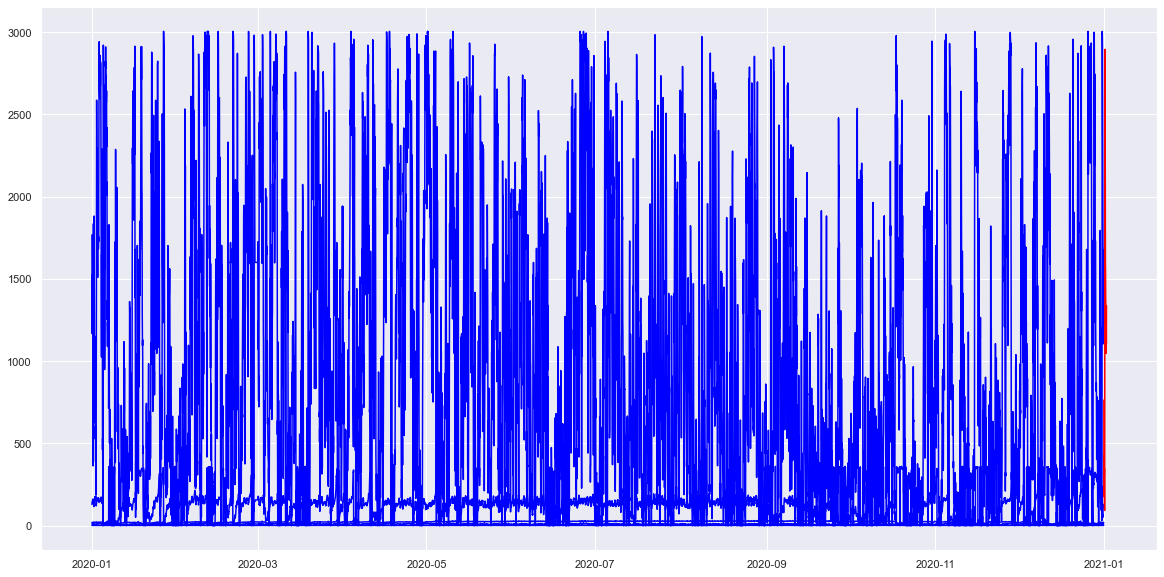

In [ ]:
model_predict = pd.DataFrame(forecast, index=steps_index, columns=['next_' + str(steps) + '_steps'])
plt.figure(figsize=(20,10))
plt.plot(df,color='blue')
plt.plot(model_predict,color='red')
plt.show()

## Printing the predicted values

In [ ]:
model_predict


,next_24_steps
2021-01-01 00:00:00,762.604198
2021-01-01 01:00:00,335.353074
2021-01-01 02:00:00,175.737215
2021-01-01 03:00:00,422.092142
2021-01-01 04:00:00,306.331943
2021-01-01 05:00:00,346.672381
2021-01-01 06:00:00,128.200475
2021-01-01 07:00:00,91.984065
2021-01-01 08:00:00,598.755353
2021-01-01 09:00:00,1971.235279
